#### Import and preprocess image dataset


In [16]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
import os
# The path of the main directory
dataset_dir=  '/content/drive/MyDrive/DiabeticRetinoPathyDataset2/messidor/'

 # The path of the train directory
train_dir = os.path.join(dataset_dir, 'train')


# The path of the normal directory inside train sub-directory
normal_train_dir = os.path.join(train_dir, 'normal')
# The path of the mild directory inside train sub-directory
mild_train_dir = os.path.join(train_dir, 'mild')
# The path of the severe directory inside train sub-directory
severe_train_dir = os.path.join(train_dir, 'severe')
# The path of the PDR directory inside train sub-directory
PDR_train_dir = os.path.join(train_dir, 'PDR')



In [18]:
print('There are {} classes: {}.\n'.format(len(os.listdir(train_dir)), os.listdir(train_dir)))
print('There are {} images in the normal directory.\n'.format(len(os.listdir(normal_train_dir))))
print('There are {} images in the mild directory.\n'.format(len(os.listdir(mild_train_dir))))
print('There are {} images in the sever directory.\n'.format(len(os.listdir(severe_train_dir))))
print('There are {} images in the PDR directory.\n'.format(len(os.listdir(PDR_train_dir))))

There are 4 classes: ['mild', 'normal', 'PDR', 'severe'].

There are 545 images in the normal directory.

There are 153 images in the mild directory.

There are 247 images in the sever directory.

There are 255 images in the PDR directory.



***
#### Using Larger Dataset



In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(
                    rescale=1./255
                    # rotation_range=40,
                    # width_shift_range=0.2,
                    # height_shift_range=0.2,
                    # horizontal_flip=True,
                    # zoom_range=0.2
                    )

# val_generator = ImageDataGenerator(rescale = 1./255)

In [20]:
train_iter = train_generator.flow_from_directory(
    directory = train_dir,
    target_size = (224, 224),
    class_mode = 'categorical',
    batch_size = 64,
    shuffle = True,
    interpolation = 'nearest')

# large_test_iter = val_gen.flow_from_directory(
#     directory = large_test_dir,
#     target_size = (224, 224),
#     class_mode = 'binary',
#     batch_size = 32)

Found 1200 images belonging to 4 classes.


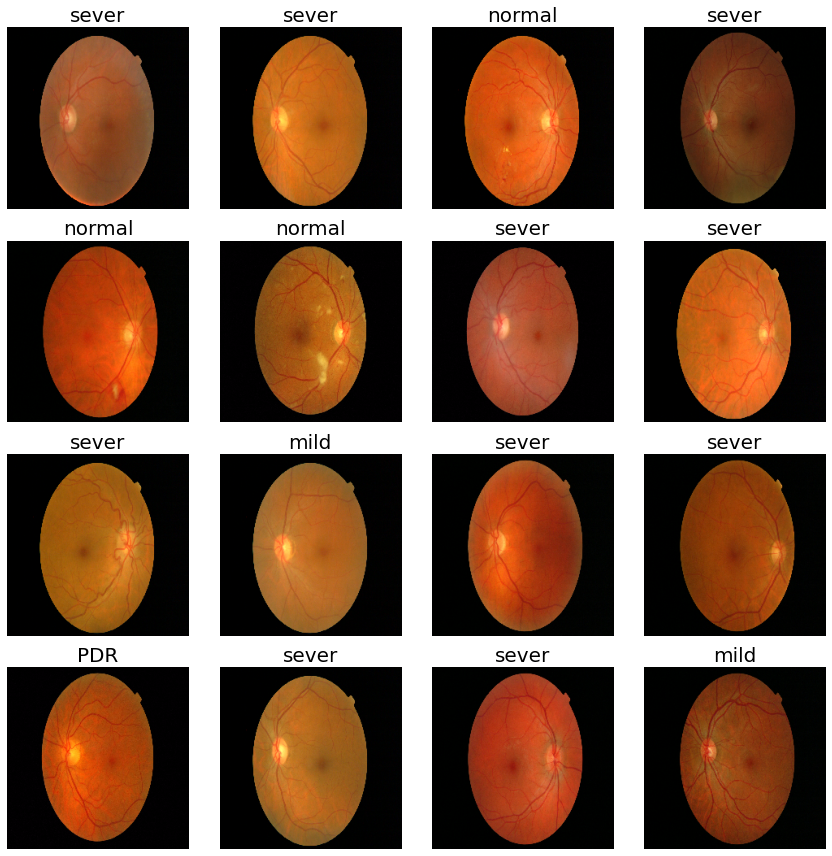

In [21]:
import matplotlib.pyplot as plt
import tensorflow as tf
images, labels = train_iter.next()

# the labels above are hot-encoded; converting them to sparse representation
sparse_labels = tf.keras.backend.argmax(labels, axis = 1).numpy()
class_names = ['normal', 'mild', 'sever', 'PDR']
plt.figure(figsize = (12, 12))
for i in range(16):
  plt.subplot(4,4,i+1)
  plt.imshow(images[i])
  # plt.title(sparse_labels[i])
  plt.title(class_names[int(sparse_labels[i])], fontsize = 20)
  plt.axis('off')

plt.tight_layout()

In [22]:

from tensorflow.keras.applications import ResNet50
model = ResNet50(
    include_top = False,
    weights = None,
    input_shape = (224, 224, 3)
)

for layer in model.layers:
  layer.trainable = True


model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [23]:
from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow as tf
last_layer_output = model.output
x = layers.Flatten()(last_layer_output)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dense(4, activation = 'softmax')(x)

model = Model(model.input, x)

model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

## Adding Callbacks



In [24]:
RLRplateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor = 'loss',
    factor = 0.5,
    patience = 2,
    verbose = 2,
    min_lr = 0.00001
)

csv_filename = '/run/log_adam_resnet50.csv'

CSV_callback = tf.keras.callbacks.CSVLogger(filename = csv_filename)

In [ ]:

history = model.fit(train_iter,  epochs = 30, callbacks=[RLRplateau, CSV_callback])

Epoch 1/30
14/19 [=====================>........] - ETA: 2:56 - loss: 1989.9554 - accuracy: 0.2935

# References
1. [How to Choose the Best Keras Pre-Trained Model for Image Classification](https://towardsdatascience.com/how-to-choose-the-best-keras-pre-trained-model-for-image-classification-b850ca4428d4)
2. [Use pre-trained Huggingface models in TensorFlow Serving](https://towardsdatascience.com/use-pre-trained-huggingface-models-in-tensorflow-serving-d2761f7e69f6)
3. [Transfer Learning in Keras with Computer Vision Models](https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/)
4. [Top 4 Pre-Trained Models for Image Classification with Python Code](https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/)
5. [Deep Residual Learning for Image Recognition](https://arxiv.org/pdf/1512.03385.pdf)
6. [Keras Applications
](https://keras.io/api/applications/#usage-examples-for-image-classification-models)
7. [AlexNet: The First CNN to win Image Net](https://www.mygreatlearning.com/blog/alexnet-the-first-cnn-to-win-image-net/)
8. [Introduction to The Architecture of Alexnet](https://www.analyticsvidhya.com/blog/2021/03/introduction-to-the-architecture-of-alexnet/)
9. [AlexNet: The Architecture that Challenged CNNs](https://towardsdatascience.com/alexnet-the-architecture-that-challenged-cnns-e406d5297951)
10. [Understanding AlexNet](https://learnopencv.com/understanding-alexnet/)
11. [AlexNet – ImageNet Classification with Deep Convolutional Neural Networks](https://neurohive.io/en/popular-networks/alexnet-imagenet-classification-with-deep-convolutional-neural-networks/)
12. [Architecture of AlexNet and its current use](https://iq.opengenus.org/architecture-and-use-of-alexnet/)
13. [Transfer Learning Guide: A Practical Tutorial With Examples for Images and Text in Keras](https://neptune.ai/blog/transfer-learning-guide-examples-for-images-and-text-in-keras)
14. [TensorFlow 2 Tutorial: Get Started in Deep Learning With tf.keras](https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/)
15. [Tensorflow Keras Tutorial - Neural Network (Part 1)](https://www.kaggle.com/akashkr/tf-keras-tutorial-neural-network-part-1)
16. [Tensorflow Keras Tutorial - Convolutional Neural Network (Part 2)](https://www.kaggle.com/akashkr/tf-keras-tutorial-cnn-part-2)
17. [Tensorflow Keras Tutorial - Binary Classification (Part 3)](https://www.kaggle.com/akashkr/tf-keras-tutorial-binary-classification-part-3)
18. [Tensorflow Keras Tutorial - Using Pretrained Models and Multiclass Classification (Part 4)](https://www.kaggle.com/akashkr/tf-keras-tutorial-pretrained-models-part-4)
19. [Tensorflow Keras Tutorial - Basics of NLP (Part 5)](https://www.kaggle.com/akashkr/tf-keras-tutorial-basics-of-nlp-part-5)

# References for Underfitting and Overfitting
1. [Underfitting and Overfitting in machine learning and how to deal with it !!!](https://towardsdatascience.com/underfitting-and-overfitting-in-machine-learning-and-how-to-deal-with-it-6fe4a8a49dbf)
2. [What Are Overfitting and Underfitting in Machine Learning?](https://towardsdatascience.com/what-are-overfitting-and-underfitting-in-machine-learning-a96b30864690)
3. [Tackling Underfitting And Overfitting Problems In Data Science](https://analyticsindiamag.com/tackling-underfitting-and-overfitting-problems-in-data-science/)
4. [Overfitting and Underfitting With Machine Learning Algorithms](https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/)